# To do:

 - Both
     - Fix Injuries data
         - Find a better source for roster data (I found, work on the plyr_pos_xref notebook)
     - Signal Opp Injuries
 - Mins
 - PTS
     - Find more effective way to signal Defensive stats
 - Res_PTS
     - See notes in Res_PTS section

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import os
import json

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

import joblib
import warnings
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")

cwd = os.path.abspath(os.getcwd()).replace("\\", "/")
if cwd.startswith("C:/Users/Rodolfo/"):
    RUN_LOCATION = "local"
    MDL_PATH = "../ML_models/dev"
else:
    RUN_LOCATION = "cloud"
    MDL_PATH = "../ML_models"
time_offset = {"local": 3, "cloud": -5}
now = str((datetime.now() + timedelta(hours=time_offset[RUN_LOCATION]) + timedelta(hours=-3)).date())
print(f"Today's date:", now)

tgt_stat = "PTS"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-24
Target Stat: PTS


In [2]:
%run ./common_utils.ipynb

# ML Functions

In [3]:
def feature_importance(model, all_features):
    booster = model.get_booster()
    score = booster.get_score(importance_type="gain")

    df_importance = pd.DataFrame({
            "feature": all_features,
            "importance": [score.get(f, 0.0) for f in all_features]
        }).sort_values("importance", ascending=False).reset_index(drop=True)
    
    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    df_importance['importance'] = df_importance['importance'].map('{:.4f}'.format)
    if df_importance.shape[0] >= 50:
        with pd.option_context('display.max_rows', None):
            display(df_importance)
    else:
        display(df_importance)
    
    xgb.plot_importance(model)
    plt.show()

In [4]:
def compute_sample_weights(df, decay=0.99):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    max_date = df['Date'].max()
    df["days_old"] = (max_date - df['Date']).dt.days
    weights = decay ** df["days_old"]
    
    return weights.values

In [5]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg', 'game_spread_type'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_L5_avg',
            'MP_L10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [6]:
def hyperparam_tuning(DFS, pred_col, is_classification=False, n_iter=20, early_stopping_rounds=50, decay=1):
    """
    Hyperparameter tuning for XGBRegressor or XGBClassifier using native XGBoost API
    """
    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Season', 'Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Sample Weights (decay < 1)
    w_train = compute_sample_weights(train_df, decay=decay)
    w_val   = compute_sample_weights(val_df, decay=decay)
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train, enable_categorical=True)
    dval   = xgb.DMatrix(X_val, label=y_val, weight=w_val, enable_categorical=True)
    dtest  = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.005, 0.08),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(3, 10),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.5, 0.5),
        "gamma": uniform(0, 0.8),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 1)
    }

    # Generate n_iter random parameter sets
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k,v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_score = float('inf') if not is_classification else 0
    best_params = None
    best_bst = None

    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')

        # Set objective based on regression or classification
        if is_classification:
            params.update({
                "objective": "binary:logistic",
                "enable_categorical": True,
                "eval_metric": "logloss",
                "tree_method": "hist",
                "device": "cuda",
                "seed": 42
            })
        else:
            params.update({
                "objective": "reg:squarederror",
                "enable_categorical": True,
                "tree_method": "hist",
                "device": "cuda",
                "seed": 42
            })

        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        # Validation scoring
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        if is_classification:
            val_class = (val_preds > 0.5).astype(int)
            score = (val_class == y_val.values).mean()  # accuracy
            print(f"Validation Accuracy: {score:.4f}")
            if score > best_score:
                best_score = score
                best_params = params.copy()
                best_bst = bst
        else:
            mae = mean_absolute_error(y_val, val_preds)
            print(f"Validation MAE: {mae:.4f}")
            if mae < best_score:
                best_score = mae
                best_params = params.copy()
                best_bst = bst

    print("\nBest score:", best_score)
    print("Best parameters:", best_params)

    # Test predictions
    test_preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    if is_classification:
        test_class = (test_preds > 0.5).astype(int)
        acc = (test_class == y_test.values).mean()
        print("\nTest Accuracy:", acc)
    else:
        print("\nTest Metrics:")
        print("RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
        print("MAE:", mean_absolute_error(y_test, test_preds))
        print("R²:", r2_score(y_test, test_preds))

    return best_params

In [7]:
def refit_model(df, pred_col, params_file, min_train_days=0, rolling_window=None, decay=1):
    df = df.sort_values("Date")
    dates = df["Date"].unique()
    print(f'Rows: {df.shape[0]}, Dates: {len(dates)}, min_train_days: {min_train_days}')

    feature_cols = [c for c in df.columns if c not in ["Season", "Date", pred_col]]

    # Load hyperparameters
    with open(f"{MDL_PATH}/{params_file}.json", "r") as f:
        loaded_params = json.load(f)

    preds, actuals, dates_out, predictions = [], [], [], []
    total_iters = len(dates) - min_train_days

    for idx, i in enumerate(range(min_train_days, len(dates)), start=1):
        test_date = dates[i]
        test_season = df.loc[df["Date"] == test_date, "Season"].iloc[0]

        if rolling_window:
            train_start_idx = max(0, i - rolling_window)
        else:
            train_start_idx = 0

        train_dates = dates[train_start_idx:i]

        train_df = df[df["Date"].isin(train_dates)]
        test_df  = df[df["Date"] == test_date]

        if test_df.empty:
            continue

        X_train, y_train = train_df[feature_cols], train_df[pred_col]
        X_test, y_test   = test_df[feature_cols], test_df[pred_col]

        predictions.append(test_df)
        if pred_col == 'Bet':
            model = XGBClassifier(**loaded_params)
            model.fit(X_train, y_train)
            
            test_df['pred_prob'] = model.predict_proba(X_test)[:,1]
            test_df['pred_class'] = (test_df['pred_prob'] > 0.5).astype(int)
        else:
            model = XGBRegressor(**loaded_params)
            sample_weights = compute_sample_weights(train_df, decay=decay)
            model.fit(X_train, y_train, sample_weight=sample_weights)

            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates_out.extend([test_date] * len(y_pred))

        if idx % max(1, total_iters // 20) == 0:
            pct = 100 * idx / total_iters
            print(f"Progress: {pct:6.2f}% ({idx}/{total_iters})")
            
    results = pd.concat(predictions)
    if pred_col == 'Res_PTS':
        results['Actuals'] = actuals
        results['Predictions'] = preds
        mae = mean_absolute_error(actuals, preds)
        print("Walk-forward MAE:", mae)
        results["Correct_Direction"] = (np.sign(results["Predictions"]) == np.sign(results["Actuals"])).astype(int)
        for t in [0, 1, 2, 3]:
            subset = results[results["Predictions"].abs() >= t]
            acc = subset["Correct_Direction"].mean() if len(subset) > 0 else np.nan
            print(f"|Pred| >= {t}: accuracy = {acc:.3f}, n = {len(subset)}")
    elif pred_col == 'Bet':
        cm = confusion_matrix(results['Bet'], results['pred_class'])
        print("Confusion Matrix:\n", cm)
        report = classification_report(results['Bet'], results['pred_class'])
        print("Classification Report:\n", report)
        auc = roc_auc_score(results['Bet'], results['pred_prob'])
        print(f"ROC AUC: {auc:.3f}")

        high_confidence = results.copy()
        high_confidence['pred_prob'] = np.where(high_confidence.pred_prob > 0.5, 1 - high_confidence.pred_prob, high_confidence.pred_prob)
        high_confidence = high_confidence[high_confidence['pred_prob'] <= 0.3]
        if len(high_confidence) > 0:
            hit_rate = (high_confidence['pred_class'] == high_confidence['Bet']).mean()
            print(f"High-confidence hit rate (<= 0.3 & >= 0.7): {hit_rate:.2f}")

    else:
        results['Actuals'] = actuals
        results['Predictions'] = preds
        mae = mean_absolute_error(actuals, preds)
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        r2 = r2_score(actuals, preds)
        print(f"Walk-forward RMSE: {rmse:.3f}")
        print(f"Walk-forward MAE: {mae:.3f}")
        print(f"Walk-forward R²: {r2:.3f}")

    return model, results

### Create Base df

In [8]:
def load_df(file_name):
    df = pd.DataFrame()
    for i in [2021, 2022, 2023, 2024, 2025]:
        df_temp = pd.read_csv(f"../tables/{i}/{file_name}.csv")
        df_temp['Season'] = i
        df = pd.concat([df, df_temp])
        
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df.Date)
    if file_name == "season_gamelogs":
        df = df[~df[['Date', 'Team', 'Player']].duplicated(keep='last')]
    
    return df

In [9]:
# Load dfs
df = load_df('nba_schedule')
df2 = load_df('season_gamelogs')
# df3 = load_df('REPLACE ME')
df4 = load_df('injuries')
df5 = load_df('plyr_pos_xref')
df6 = load_df('daily_lineups')
gmlog_cols = ['game_id', 'Player', 'MP', 'PF']
df7 = load_df('h1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h1", "PF": "PF_h1"})
df8 = load_df('h2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h2", "PF": "PF_h2"})
df9 = load_df('q1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q1", "PF": "PF_q1"})
df10 = load_df('q2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q2", "PF": "PF_q2"})
df11 = load_df('q3_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q3", "PF": "PF_q3"})
df12 = load_df('q4_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q4", "PF": "PF_q4"})

df_mtch = df[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df = pd.concat([df_mtch, df_mtch2])
df = df.sort_values(["Team", "Date"])
df['team_game_num'] = df.groupby(["Team", "Season"]).cumcount() + 1
df['Spread'] = np.where(df.Team_type == 'Home', df.AwayPTS - df.HomePTS, df.HomePTS - df.AwayPTS)
df['Total'] = df.AwayPTS + df.HomePTS
df['is_Win'] = np.where(df.Spread > 0, 1, 0)
df['Szn_Wins'] = df.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.merge(df5, on=['Season', 'Team'])

df2 = df2.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"})
df2['PR'] = df2.PTS + df2.REB 
df2['PA'] = df2.PTS + df2.AST
df2['RA'] = df2.REB + df2.AST
df2['PRA'] = df2.PTS + df2.REB + df2.AST
df2['STL_BLK'] = df2.STL + df2.BLK
df = df.merge(df2.drop(['Pos', 'Opp', 'Team_type'], axis=1), on=['Season', 'Date', 'Team', 'Player'], how='left')

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

df6['role'] = 1
df = df.merge(df6.drop('Pos', axis=1), on=['Season', 'Date', 'Team', 'Player'], how='left')
df['role'] = df.role.fillna(2).astype(int)

# Add gmlog splits
df_gmlog_comb = df7.merge(df8, on=['game_id', 'Player'])
for df_loop in (df9, df10, df11, df12):
    df_gmlog_comb = df_gmlog_comb.merge(df_loop, on=['game_id', 'Player'])
df = df.merge(df_gmlog_comb, on=['game_id', 'Player'], how='left')

df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull()) & ~(df_lines.PTS_line.isnull())].drop(['Pos', 'Spread', 'Total'], axis=1)
df = df.merge(df_lines, on=['Date', 'Team', 'Player'], how='left')
df['Res_PTS'] = df.PTS - df.PTS_line

df = df.sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
df_td = df[df.Date == now]
df = df[(df.Active == 1) & (df.MP > 0)]
df_pred = df.copy()
df_pred = pd.concat([df_pred, df_td])
print('base df created', datetime.now())

base df created 2026-01-24 14:04:27.735865


### Create missing_df

In [10]:
def create_df_missing(df, pred_col):

    df3 = load_df('season_gamelogs')
    df3 = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
    df4 = load_df('injuries')
    
    # Fill missing games from injuries.csv
    team_games = df_pred[['Season', 'Team', 'Date']].drop_duplicates()
    players = df_pred[['Season','Player','Team']].drop_duplicates()
    fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
    fabricated['Season'] = fabricated['Season'] + 1
    players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
    expanded = team_games.merge(players, on=['Season', 'Team'], how='left')

    df5 = load_df('plyr_pos_xref')

    expanded = expanded.merge(df3[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
    expanded = expanded[(expanded.MP.isnull()) & (expanded.Date != now)].drop('MP', axis=1)
    expanded = pd.concat([expanded, df4[df4.Status == 'Out'][['Season', 'Team', 'Date', 'Player']]])
    df4 = df4.merge(expanded, on=['Season', 'Date', 'Team', 'Player'], how='right')

    # Grab outs from players season gamelogs
    df4 = df4.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='outer')
    df4['Status'] = np.where(((df4.Active == 1) | (df4.MP > 0)), 'Available', df4.Status)
    df4['Status'] = np.where(((df4.Active == 0) | (df4.MP == 0) | (df4.MP.isnull())), 'Out', df4.Status)
    df4['Status'] = np.where((df4.Status == 'Out') & (df4.MP > 0), 'Available', df4.Status)
    df4['Status'] = np.where((df4.Status != 'Out') & (df4.MP == 0), 'Out', df4.Status)
    df4 = df4[df4.Status == 'Out'][['Season', 'Date', 'Team', 'Player']].drop_duplicates()
    
    df_missing = df[['Season', 'Date', 'Team', 'Player', 'role', pred_col]].copy()
    df_missing[f'{pred_col}_L10'] = (
        df_missing.sort_values(['Player', 'Date']).groupby(['Player','Season'])[pred_col].shift(1)
                  .transform(lambda x: x.rolling(10, min_periods=10).mean())
    )
    df_missing['role_L10_mode'] = (
        df_missing.sort_values(['Player', 'Date'])
            .groupby(['Player', 'Season'])['role'].shift(1)
            .transform(lambda x: x.rolling(10, min_periods=10)
                            .apply(lambda y: np.bincount(y.astype(np.int8), minlength=4).argmax(), raw=True))
    )
    df_missing = pd.merge_asof(df4, df_missing[["Season", "Player", "Date", "role", "role_L10_mode", f"{pred_col}_L10"]], 
                      on="Date", by=["Player", "Season"], direction="backward", allow_exact_matches=True).dropna()   
    df_missing = df_missing.merge(df5, on=['Season', 'Team', 'Player'])
    
    # Filter out old injuries
    df_missing = df_missing.sort_values(["Season", "Team", "Player", "Date"])
    df_missing["team_game_num"] = (df_missing.groupby(["Season", "Team"])["Date"].rank(method="dense").astype(int))
    df_missing["game_break"] = (df_missing.groupby(["Season", "Team", "Player"])["team_game_num"].diff().ne(1))
    df_missing["streak_id"] = (df_missing.groupby(["Season", "Team", "Player"])["game_break"].cumsum())
    df_missing["consecutive_games"] = (df_missing.groupby(["Season", "Team", "Player", "streak_id"]).cumcount().add(1))
    df_missing["eligible_today"] = (df_missing["consecutive_games"] <= 10).astype(int)
    df_missing["role_for_count"] = np.where(df_missing["eligible_today"] == 1, df_missing["role_L10_mode"], np.nan)    
    df_missing[f'{pred_col}_L10'] = np.where(df_missing['role_for_count'] == 1, df_missing[f'{pred_col}_L10'], 0)

#     display(df_missing[(df_missing.Team == 9) & (df_missing.Player == 'Jimmy Butler')].tail(50))

    out_minutes = (
    df_missing
      .groupby(["Season", "Date", "Team"])
      .agg(
          tgt_available=(f"{pred_col}_L10", lambda x: x.sum()),
          starters_out=("role_for_count", lambda x: (x == 1).sum())
      )
      .reset_index()
    ).rename(columns={"tgt_available": f"team_{pred_col}_available"})

    return out_minutes

# Minutes Projection Model

In [11]:
def setup_df_mins(con, df):

    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'role',
             'MP', 'Spread', 'team_game_num', 'is_OT']]    
    cleanup_cols = []
    cold_features = []
    
    df['team_mins_pct'] = df['MP'] / (240 + (df.is_OT * 25))
    for col in ['MP', 'team_mins_pct']:
        for N in [3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                 .rolling(window=N, min_periods=N)
                 .mean()
            )
            df[f'is_cold_{col}_L{N}'] = (df.groupby(['Player', 'Season']).cumcount() < N).astype(int)
            cold_features.append(f'is_cold_{col}_L{N}')
            cleanup_cols.append(f'{col}_L{N}_avg')
    df['MP_base'] = ((df['MP_L3_avg'] * 0.15) + (df['MP_L5_avg'] * 0.25) + (df['MP_L10_avg'] * 0.6))
    df['MP_tm_pct_base'] = ((df['team_mins_pct_L3_avg'] * 0.15) + (df['team_mins_pct_L5_avg'] * 0.25) + (df['team_mins_pct_L10_avg'] * 0.6))
    df['role'] = np.where((df.role == 2) & (df.MP_base < 13), 3, df.role)
    
    games_last_14_days = df.sort_values(['Player', 'Season', 'Date']).groupby(['Player', 'Season']).rolling('14D', on='Date', closed='left')['MP'].count().reset_index().rename(columns={"MP": "gms_L14_days"})
    games_last_14_days = games_last_14_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_14_days, on=['Player', 'Season', 'Date'])
    df['gms_L14_days'] = df.gms_L14_days.fillna(0).astype(int)    
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))
    df['games_since_return'] = (df.groupby(['Player', 'Team', 'Season']).apply(
                                    lambda g: (
                                        (g['team_game_num'].diff().sub(1).fillna(0).gt(0))
                                        .cumsum()
                                        .groupby((g['team_game_num'].diff().sub(1).fillna(0).gt(0)).cumsum()).cumcount()
                                    )
                                ).reset_index(level=[0,1,2], drop=True))

    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])['role'].shift(1)
              .transform(lambda x: x.rolling(N, min_periods=N)
                            .apply(lambda y: np.bincount(y.astype(np.int8), minlength=4).argmax(), raw=True))
        )
        df[f'is_cold_recent_role_L{N}'] = (df.groupby(['Player', 'Season']).cumcount() < N).astype(int)
        cold_features.append(f'is_cold_recent_role_L{N}')
        cleanup_cols.append(f"recent_role_L{N}")
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread) < 13, 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread) >= 13) & (abs(df.Spread) <= 21), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread) > 21, 3, df.game_spread_type) 
    
    df2 = create_df_missing(df, 'MP')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    for col in ['starters_out', 'team_MP_available']:
        df[col] = df[col].fillna(0).astype(int)
        
    df['starters_returning'] = ((df['missed_games'] > 0) & (df['role'] == 1)).astype(int)
    df['returning_MP'] = (
        (df['MP_L10_avg'] * df['starters_returning'])
        .groupby([df['Team'], df['Date']])
        .transform('sum')
    )
    
    df['starters_returning'] = df.sort_values(['Team', 'Date']).groupby(['Team', 'Date'])['starters_returning'].transform('sum')
    df['team_MP_available'] = df['team_MP_available'] - df['returning_MP']

    df['MP_Change'] = 0
    MP_Inc_conds = (
#                     ((df.role != 3) & (df.starters_out > 2)) | 
                    ((df.role == 1) & (df.recent_role_L1 > 1.0)).astype(int) + 
                    (df.team_MP_available >=110).astype(int)
                   )
    
    MP_Dec_conds = (
                    ((df.role > 1) & ((df.recent_role_L1 == 1.0))).astype(int) 
                   ) * -1
    df['MP_Change'] = MP_Inc_conds + MP_Dec_conds


    df['scenario_mins'] = (
        df.sort_values(['Season','Team','role','Pos','Date'])
          .groupby(['Season','Team','role','Pos'])[col].shift(1)
          .expanding()
          .mean() 
          .reset_index(drop=True)
    )
    
    df['Expected_MP'] = (
        (0.8 * df['scenario_mins']) +
        (df['team_MP_available'] * df['MP_tm_pct_base']) + 
        (0.2 * df['MP_base'])
    )
    df["is_cold_start"] = (df[cold_features].eq(1).any(axis=1).astype(int))

    df['Team'] = df['Team'].astype('category')
    df['Opp'] = df['Opp'].astype('category')
    df['Player'] = df['Player'].astype('category')
    df['Pos'] = df['Pos'].astype('category')
    df = df.drop(['Team_type', 'team_game_num', 'is_OT', 'Spread', 'starters_out', 'team_mins_pct', 'MP_tm_pct_base', 
                  'returning_MP', 'scenario_mins'] + cleanup_cols + cold_features, axis=1)      

    return df

,Season,Date,Team,Opp,Player,Pos,role,MP,MP_base,gms_L14_days,missed_games,games_since_return,game_spread_type,team_MP_available,starters_returning,MP_Change,Expected_MP,is_cold_start
0,2021,2021-10-19,BRK,MIL,Blake Griffin,C,1,22.98,NaN,0,0,0,3,0.000,0,0,NaN,1
1,2021,2021-10-19,BRK,MIL,Bruce Brown,SF,2,3.75,NaN,0,0,0,3,0.000,0,0,NaN,1
2,2021,2021-10-19,BRK,MIL,Cam Thomas,SG,2,3.75,NaN,0,0,0,3,0.000,0,0,NaN,1
3,2021,2021-10-19,BRK,MIL,DeAndre' Bembry,SF,2,3.75,NaN,0,0,0,3,0.000,0,0,NaN,1
4,2021,2021-10-19,BRK,MIL,James Harden,PG,1,30.63,NaN,0,0,0,3,0.000,0,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126636,2025,2026-01-23,TOR,POR,Jonathan Mogbo,PF,3,3.95,10.2110,6,0,3,1,1.125,1,0,20.777772,0
126637,2025,2026-01-23,TOR,POR,Ochai Agbaji,SG,2,21.52,17.8566,7,0,7,1,1.125,1,0,22.340448,0
126638,2025,2026-01-23,TOR,POR,RJ Barrett,SF,1,21.37,29.4895,1,7,0,1,1.125,1,0,24.722931,0
126639,2025,2026-01-23,TOR,POR,Sandro Mamukelashvili,C,1,34.85,25.2431,7,0,4,1,1.125,1,0,23.852982,0


Rows: 126641, Dates: 940, min_train_days: 910
Progress:   3.33% (1/30)
Progress:   6.67% (2/30)
Progress:  10.00% (3/30)
Progress:  13.33% (4/30)
Progress:  16.67% (5/30)
Progress:  20.00% (6/30)
Progress:  23.33% (7/30)
Progress:  26.67% (8/30)
Progress:  30.00% (9/30)
Progress:  33.33% (10/30)
Progress:  36.67% (11/30)
Progress:  40.00% (12/30)
Progress:  43.33% (13/30)
Progress:  46.67% (14/30)
Progress:  50.00% (15/30)
Progress:  53.33% (16/30)
Progress:  56.67% (17/30)
Progress:  60.00% (18/30)
Progress:  63.33% (19/30)
Progress:  66.67% (20/30)
Progress:  70.00% (21/30)
Progress:  73.33% (22/30)
Progress:  76.67% (23/30)
Progress:  80.00% (24/30)
Progress:  83.33% (25/30)
Progress:  86.67% (26/30)
Progress:  90.00% (27/30)
Progress:  93.33% (28/30)
Progress:  96.67% (29/30)
Progress: 100.00% (30/30)
Walk-forward RMSE: 5.626
Walk-forward MAE: 4.247
Walk-forward R²: 0.698


,feature,importance,pct
0,role,151937.1719,0.679151
1,MP_base,27052.9219,0.800076
2,Player,10063.2979,0.845058
3,Expected_MP,6311.4600,0.873270
4,gms_L14_days,5036.0137,0.895781
5,games_since_return,4550.3252,0.916121
6,is_cold_start,4422.9722,0.935891
7,MP_Change,3982.9019,0.953694
8,missed_games,2903.4941,0.966673
9,game_spread_type,2792.9758,0.979157


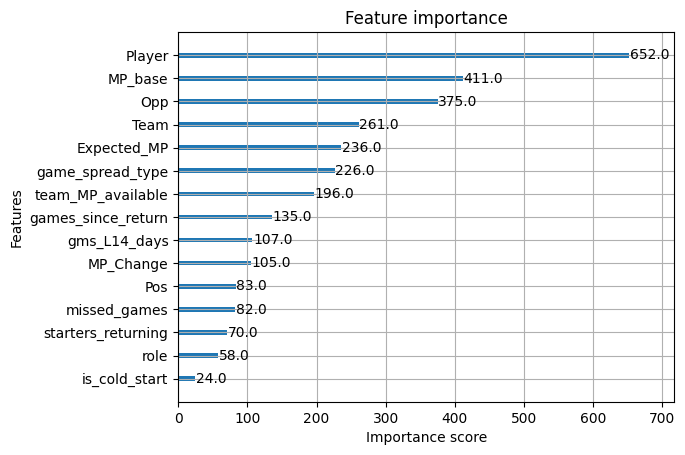

Saved Mins booster!


In [12]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

game_dates = (df_mins[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_cut = int(0.70 * n_days)
val_cut   = int(0.80 * n_days)
train_end = game_dates.loc[train_cut, 'Date']
val_end   = game_dates.loc[val_cut, 'Date']

mins_train_df = df_mins[df_mins['Date'] <= train_end]
mins_val_df   = df_mins[(df_mins['Date'] > train_end) & (df_mins['Date'] <= val_end)]
mins_test_df  = df_mins[df_mins['Date'] > val_end]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# Prev r2/mae/rmse best: 0.6963/4.4237/5.8326 [1/18/2026]
# mins_params = hyperparam_tuning(mins_DFS, "MP", n_iter=25)
# with open(f"{MDL_PATH}/mins_params.json", "w") as f:
#     json.dump(mins_params, f)

# Prev r2/mae/rmse best: 0.693/4.339/5.727 [1/21/2026]
mins_model, mins_results = refit_model(df_mins, 'MP', 'mins_params', min_train_days=910, rolling_window=270)
feature_importance(mins_model, df_mins.columns.tolist())

mins_model.get_booster().save_model(f"{MDL_PATH}/mins_model.json")
print('Saved Mins booster!')

In [14]:
# analyze_df = mins_results.copy()
# analyze_df['Diff'] = analyze_df.Predictions - analyze_df.Actuals
# display(analyze_df[analyze_df.Date.isin(['2026-01-23'])].sort_values('Diff', ascending=True).head(10))

# plt.figure(figsize=(10,6))
# hist_col = 'Diff'
# plt.hist(analyze_df[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [15]:
# df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
# df_lines['Date'] = pd.to_datetime(df_lines.Date)
# df_lines = df_lines[~(df_lines.Team.isnull())]

# df_lines["Team"] = team_encoder.transform(df_lines["Team"])
# df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
# df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
# df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
# df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
# df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
# df_prediction = df_pred.copy()

# # Predict Mins
# mins_booster = xgb.Booster()
# mins_booster.load_model("../ML_models/dev/mins_model.json")
# mins_model = XGBRegressor()
# mins_model._Booster = mins_booster

# df_prediction_mins = setup_df_mins(con, df_prediction)
# df_prediction_mins['MP_preds'] = mins_model.predict(df_prediction_mins.drop(['Season', 'Date', 'MP'], axis=1))
# df_prediction_mins = df_prediction_mins[df_prediction_mins.Date == now]

# df_prediction_mins['Team'] = team_encoder.inverse_transform(df_prediction_mins["Team"])
# df_prediction_mins['Opp'] = team_encoder.inverse_transform(df_prediction_mins["Opp"])
# df_prediction_mins['Player'] = player_encoder.inverse_transform(df_prediction_mins["Player"])

# if df_prediction_mins.shape[0] >= 50:
#     print(df_prediction_mins.shape[0], 'rows')
#     for tm in df_prediction_mins.Team.unique():
#         display(df_prediction_mins[df_prediction_mins.Team == tm])
# else:
#     display(df_prediction_mins)

# Stats Model

In [16]:
def setup_df_main(df, tgt_stat):
    
    df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'role', 'MP', 'team_game_num', 
             'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'Spread', 'Total']]
    cleanup_cols = []
    
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))
    df['TeamPTS'] = (df.Total + (df.Spread * -1)) / 2
    df['TeamPTS_type'] = 0
    df['TeamPTS_type'] = np.where((df.TeamPTS < 110), 1, df.TeamPTS_type)
    df['TeamPTS_type'] = np.where((df.TeamPTS >= 110) & (df.TeamPTS <= 130), 2, df.TeamPTS_type)
    df['TeamPTS_type'] = np.where((df.TeamPTS > 130), 3, df.TeamPTS_type)
    
    # Create rolling + lag features
    df['eFG'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
    df['TS']  = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
    df['TeamPTS_pct'] = df['PTS'] / df['TeamPTS']

    # Create rolling + lag features    
    for col in ['MP', tgt_stat, 'TeamPTS_pct', 'FGA']:
        for N in [1, 3, 5, 10]:
            if col == f'Def{tgt_stat}':
                df[f'Def{tgt_stat}_L{N}_avg'] = (
                    df[df.role <= 2]
                      .groupby(['Season', 'Date', 'Opp', 'Pos'])[tgt_stat]
                      .sum()
                      .groupby(['Opp', 'Pos', 'Season'])
                      .shift(1)
                      .rolling(window=N, min_periods=N)
                      .mean()
                      .reindex(df.set_index(['Season', 'Date', 'Opp', 'Pos']).index)
                      .values
                )
            else:
                df[f'{col}_L{N}_avg'] = (
                    df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                     .rolling(window=N, min_periods=N)
                     .mean()
                )
            cleanup_cols.append(f'{col}_L{N}_avg')
        df[f'{col}_base'] = ((df[f'{col}_L3_avg'] * 0.15) + (df[f'{col}_L5_avg'] * 0.25) + (df[f'{col}_L10_avg'] * 0.6))
    
    df['role'] = np.where((df.role == 2) & (df.MP_base < 13), 3, df.role)

#     df[['pts_low', 'pts_mid', 'pts_high']] = pd.DataFrame({
#         'pts_low': ((110 - df.TeamPTS) / 20).clip(lower=0),
#         'pts_mid': (1 - abs(df.TeamPTS - 120) / 20).clip(lower=0),
#         'pts_high': ((df.TeamPTS - 130) / 20).clip(lower=0)
#     }, index=df.index)
#     w = df[['pts_low','pts_mid','pts_high']]
#     df[['pts_low','pts_mid','pts_high']] = w.div(w.sum(axis=1).replace(0,1), axis=0)
    
    df2 = create_df_missing(df, tgt_stat)
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    for col in ['starters_out', f'team_{tgt_stat}_available']:
        df[col] = df[col].fillna(0)
    
    df['starters_returning'] = ((df['missed_games'] > 0) & (df['role'] == 1)).astype(int)
    df[f'returning_{tgt_stat}'] = (
        (df[f'{tgt_stat}_L10_avg'] * df['starters_returning'])
        .groupby([df['Team'], df['Date']])
        .transform('sum')
    )
    
    df['starters_returning'] = df.sort_values(['Team', 'Date']).groupby(['Team', 'Date'])['starters_returning'].transform('sum')
    df[f'team_{tgt_stat}_available'] = df[f'team_{tgt_stat}_available'] - df[f'returning_{tgt_stat}']
    
#     df['ProjPts'] = (df.TeamPTS * df.TeamPTS_pct_L10) + (df.team_PTS_available * df.TeamPTS_pct_L10) # TeamPTS is LEAKING
    df[f'scenario_{tgt_stat}'] = (
        df.sort_values(['Season','Team','role','Pos','Date'])
          .groupby(['Season','Team','role','Pos'])[col].shift(1)
          .expanding()
          .mean() 
          .reset_index(drop=True)
    )
    
    df[f'Expected_{tgt_stat}'] = (
        (0.8 * df[f'scenario_{tgt_stat}']) +
        (df[f'team_{tgt_stat}_available'] * df['TeamPTS_pct_base']) + 
        (0.2 * df[f'{tgt_stat}_base'])
    )
    
    df['Team'] = df['Team'].astype('category')
    df['Opp'] = df['Opp'].astype('category')
    df['Player'] = df['Player'].astype('category')
    df['Pos'] = df['Pos'].astype('category')
    df = df.drop(['team_game_num', 'missed_games', 'Spread', 'Total', 'role', 'MP_base', 'TeamPTS', 'TeamPTS_pct', 
                 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'eFG', 'TS',
                 f'returning_{tgt_stat}', 'starters_out', 'starters_returning', f'scenario_{tgt_stat}', f'team_{tgt_stat}_available'
                 ] + cleanup_cols, axis=1)

    return df

,Season,Date,Team,Opp,Player,Pos,MP,PTS,TeamPTS_type,PTS_base,TeamPTS_pct_base,FGA_base,Expected_PTS
0,2021,2021-10-19,BRK,MIL,Blake Griffin,C,22.98,6.0,1,NaN,NaN,NaN,NaN
1,2021,2021-10-19,BRK,MIL,Bruce Brown,SF,3.75,0.0,1,NaN,NaN,NaN,NaN
2,2021,2021-10-19,BRK,MIL,Cam Thomas,SG,3.75,2.0,1,NaN,NaN,NaN,NaN
3,2021,2021-10-19,BRK,MIL,DeAndre' Bembry,SF,3.75,0.0,1,NaN,NaN,NaN,NaN
4,2021,2021-10-19,BRK,MIL,James Harden,PG,30.63,20.0,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126636,2025,2026-01-23,TOR,POR,Jonathan Mogbo,PF,3.95,0.0,2,2.32,0.021434,2.01,9.694996
126637,2025,2026-01-23,TOR,POR,Ochai Agbaji,SG,21.52,10.0,2,4.51,0.037668,4.70,9.960843
126638,2025,2026-01-23,TOR,POR,RJ Barrett,SF,21.37,10.0,2,20.70,0.180276,16.48,11.687120
126639,2025,2026-01-23,TOR,POR,Sandro Mamukelashvili,C,34.85,22.0,2,14.27,0.125359,9.60,10.983291


Rows: 126641, Dates: 940, min_train_days: 910
Progress:   3.33% (1/30)
Progress:   6.67% (2/30)
Progress:  10.00% (3/30)
Progress:  13.33% (4/30)
Progress:  16.67% (5/30)
Progress:  20.00% (6/30)
Progress:  23.33% (7/30)
Progress:  26.67% (8/30)
Progress:  30.00% (9/30)
Progress:  33.33% (10/30)
Progress:  36.67% (11/30)
Progress:  40.00% (12/30)
Progress:  43.33% (13/30)
Progress:  46.67% (14/30)
Progress:  50.00% (15/30)
Progress:  53.33% (16/30)
Progress:  56.67% (17/30)
Progress:  60.00% (18/30)
Progress:  63.33% (19/30)
Progress:  66.67% (20/30)
Progress:  70.00% (21/30)
Progress:  73.33% (22/30)
Progress:  76.67% (23/30)
Progress:  80.00% (24/30)
Progress:  83.33% (25/30)
Progress:  86.67% (26/30)
Progress:  90.00% (27/30)
Progress:  93.33% (28/30)
Progress:  96.67% (29/30)
Progress: 100.00% (30/30)
Walk-forward RMSE: 4.894
Walk-forward MAE: 3.711
Walk-forward R²: 0.685


,feature,importance,pct
0,MP,6717.4014,0.357042
1,Player,5389.0532,0.643480
2,FGA_base,2807.3059,0.792693
3,PTS_base,1269.1836,0.860152
4,TeamPTS_pct_base,1154.5647,0.921519
5,TeamPTS_type,569.1952,0.951773
6,Opp,283.3383,0.966833
7,Expected_PTS,280.8648,0.981761
8,Team,242.9229,0.994673
9,Pos,100.2174,1.000000


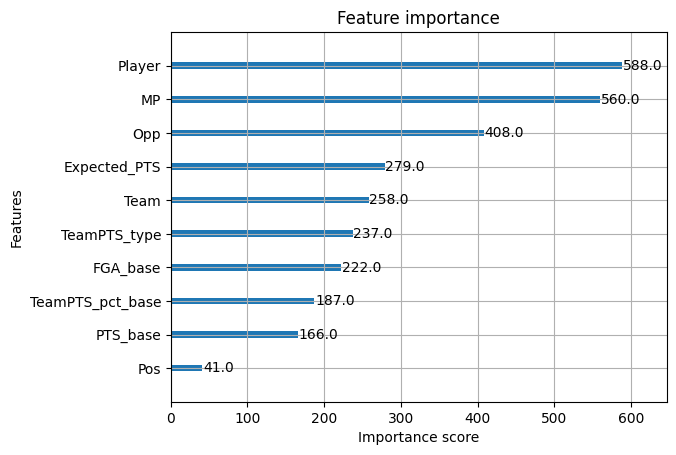

Saved PTS booster!


In [17]:
df_main = df.copy()
df_main = setup_df_main(df_main, tgt_stat)
display(df_main)

game_dates = (df_main[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_cut = int(0.70 * n_days)
val_cut   = int(0.80 * n_days)
train_end = game_dates.loc[train_cut, 'Date']
val_end   = game_dates.loc[val_cut, 'Date']

main_train_df = df_main[df_main['Date'] <= train_end]
main_val_df   = df_main[(df_main['Date'] > train_end) & (df_main['Date'] <= val_end)]
main_test_df  = df_main[df_main['Date'] > val_end]
main_DFS = (main_train_df, main_val_df, main_test_df)

# Prev r2/mae/rmse best: 0.6706/3.7633/5.0858 [1/24/2026]
# stat_params = hyperparam_tuning(main_DFS, tgt_stat, n_iter=25, decay=0.99)
# with open(f"{MDL_PATH}/{tgt_stat}_params.json", "w") as f:
#     json.dump(stat_params, f)

# Prev r2/mae/rmse best: 0.695/3.628/4.840 [1/21/2026]
stat_model, stat_results = refit_model(df_main, tgt_stat, f'{tgt_stat}_params', min_train_days=910, decay=0.99)
feature_importance(stat_model, df_main.columns.tolist())

stat_model.get_booster().save_model(f"{MDL_PATH}/{tgt_stat}_model.json")
print(f"Saved {tgt_stat} booster!")

In [18]:
# analyze_df = stat_results.copy()
# analyze_df['Team'] = team_encoder.inverse_transform(analyze_df['Team'])
# analyze_df['Opp'] = team_encoder.inverse_transform(analyze_df['Opp'])
# analyze_df['Player'] = player_encoder.inverse_transform(analyze_df['Player'])
# analyze_df['Diff'] = analyze_df.Predictions - analyze_df.Actuals
# display(analyze_df[analyze_df.Date.isin(['2026-01-22'])].sort_values('Diff', ascending=True).iloc[10:].head(10))

# plt.figure(figsize=(10,6))
# hist_col = 'Diff'
# plt.hist(analyze_df[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

# Residual PTS

##### Try some sort of defensive rk L5 - d_rk today feature to measure difficulty increase/decrease
##### Create some short term Lx Average features for the target columns (Res_PTS/Bet)

In [19]:
def setup_df_res(df):
    
    df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'role', 'MP', 'team_game_num', 'Res_PTS', 'PTS_line',  
             'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 
             'Spread', 'Total']]
    
    # Create rolling + lag features
    df3 = load_df('season_gamelogs')
    df3 = con.execute("""SELECT Date, Team, CAST(ROUND(SUM(MP), 0) as INT) as Team_Mins, 
                         CAST(SUM(FGA) as INT) as Team_FGA, CAST(SUM(FTA) as INT) as Team_FTA, CAST(SUM(TOV) as INT) as Team_TOV 
                         FROM df3
                         GROUP BY Date, Team""").fetchdf()
    df = df.merge(df3, on=['Date', 'Team'], how='left')
    df['eFG'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
    df['TS']  = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
    df['USG'] = (
        (df['FGA'] + 0.44*df['FTA'] + df['TOV']) * (df['Team_Mins'] / 5)
        / (df['MP'] * (df['Team_FGA'] + 0.44*df['Team_FTA'] + df['Team_TOV']))
    )

    LN_cols = []
    for col in ['MP', 'PTS', 'eFG', 'TS', 'USG']:
        for N in [3, 10]:
            if col != 'else':
                df[f'{col}_L{N}_avg'] = (
                    df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                     .rolling(window=N, min_periods=N)
                     .mean()
                )

                if col not in ['MP']:
                    LN_cols.append(f'{col}_L{N}_avg')
        df[f'{col}_trend'] = df[f'{col}_L3_avg'] - df[f'{col}_L10_avg']
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread) < 13, 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread) >= 13) & (abs(df.Spread) <= 18), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread) > 18, 3, df.game_spread_type) 
    
    df['TeamPTS'] = (df.Total + (df.Spread * -1)) / 2
#     df['TeamPTS_type'] = 0
#     df['TeamPTS_type'] = np.where((df.TeamPTS < 110), 1, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS >= 110) & (df.TeamPTS <= 130), 2, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS > 130), 3, df.TeamPTS_type)

    df[['pts_low', 'pts_mid', 'pts_high']] = pd.DataFrame({
        'pts_low': ((110 - df.TeamPTS) / 20).clip(lower=0),
        'pts_mid': (1 - abs(df.TeamPTS - 120) / 20).clip(lower=0),
        'pts_high': ((df.TeamPTS - 130) / 20).clip(lower=0)
    }, index=df.index)
#     w = df[['pts_low','pts_mid','pts_high']]
#     df[['pts_low','pts_mid','pts_high']] = w.div(w.sum(axis=1).replace(0,1), axis=0)
        
    for col in ['TeamPTS']:
        for N in [3, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                  .rolling(window=N, min_periods=N)
                  .mean()
            )
            df[f'PTS_pct_L{N}'] = df[f'PTS_L{N}_avg'] / df[f'TeamPTS_L{N}_avg']
            df = df.drop(f'TeamPTS_L{N}_avg', axis=1)
        df['PTS_pct_trend'] = df['PTS_pct_L3'] - df['PTS_pct_L10']
        df = df.drop(['PTS_pct_L3', 'PTS_pct_L10'], axis=1)
    
    df2 = create_df_missing(df, 'PTS')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    for col in ['starters_out', 'team_PTS_available']:
        df[col] = df[col].fillna(0)
    df['starters_out_L1'] = (
        df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])['starters_out'].shift(1)
          .rolling(window=1, min_periods=1)
          .mean()
    )
    df['starters_returning'] = np.where(df['starters_out_L1'] > df['starters_out'], df['starters_out_L1'] - df['starters_out'], 0)

    df['Team'] = df['Team'].astype('category')
    df['Opp'] = df['Opp'].astype('category')
    df['Player'] = df['Player'].astype('category')
    df['Pos'] = df['Pos'].astype('category')
    df = df.drop(['team_game_num', 'Spread', 'Total', 'TeamPTS', 'Team_FGA', 'Team_FTA', 'Team_TOV', 
                 'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'eFG', 'TS', 'USG', 
                  'Team_Mins', 'starters_out_L1'] + LN_cols, axis=1)
        
    return df

##### Regressor

In [20]:
df_res = df[(~df.PTS_line.isnull())].copy()
df_res = setup_df_res(df_res)
# display(df_res)

game_dates = (df_res[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_cut = int(0.70 * n_days)
val_cut   = int(0.80 * n_days)
train_end = game_dates.loc[train_cut, 'Date']
val_end   = game_dates.loc[val_cut, 'Date']

res_train_df = df_res[df_res['Date'] <= train_end]
res_val_df   = df_res[(df_res['Date'] > train_end) & (df_res['Date'] <= val_end)]
res_test_df  = df_res[df_res['Date'] > val_end]
res_DFS = (res_train_df, res_val_df, res_test_df)

# Prev r2/mae/rmse best: 0.2124/4.3069/5.6478 [1/24/2026]
# res_params = hyperparam_tuning(res_DFS, 'Res_PTS', n_iter=25)
# with open(f"{MDL_PATH}/Res_PTS_RG_params.json", "w") as f:
#     json.dump(res_params, f)

# Prev mae best: 4.1101 [1/18/2026]
res_model, res_results = refit_model(df_res, 'Res_PTS', 'Res_PTS_RG_params', min_train_days=50)
# feature_importance(res_model, df_res.columns.tolist())

res_model.get_booster().save_model(f"{MDL_PATH}/Res_PTS_RG_model.json")
print("Saved Res_PTS_RG booster!")

Rows: 5492, Dates: 63, min_train_days: 50
Progress:   7.69% (1/13)
Progress:  15.38% (2/13)
Progress:  23.08% (3/13)
Progress:  30.77% (4/13)
Progress:  38.46% (5/13)
Progress:  46.15% (6/13)
Progress:  53.85% (7/13)
Progress:  61.54% (8/13)
Progress:  69.23% (9/13)
Progress:  76.92% (10/13)
Progress:  84.62% (11/13)
Progress:  92.31% (12/13)
Progress: 100.00% (13/13)
Walk-forward MAE: 4.223000701021085
|Pred| >= 0: accuracy = 0.651, n = 1345
|Pred| >= 1: accuracy = 0.693, n = 952
|Pred| >= 2: accuracy = 0.746, n = 638
|Pred| >= 3: accuracy = 0.812, n = 367
Saved Res_PTS_RG booster!


##### Classifier

In [21]:
df_res = df[(~df.PTS_line.isnull())].copy()
df_res = setup_df_res(df_res)
df_res['Bet'] = (df_res['Res_PTS'] > 0).astype(int)  # 1 = over, 0 = under
df_res = df_res.drop('Res_PTS', axis=1)
# display(df_res)

game_dates = (df_res[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_cut = int(0.70 * n_days)
val_cut   = int(0.80 * n_days)
train_end = game_dates.loc[train_cut, 'Date']
val_end   = game_dates.loc[val_cut, 'Date']

res_train_df = df_res[df_res['Date'] <= train_end]
res_val_df   = df_res[(df_res['Date'] > train_end) & (df_res['Date'] <= val_end)]
res_test_df  = df_res[df_res['Date'] > val_end]
res_DFS = (res_train_df, res_val_df, res_test_df)

# Test Accuracy: 0.6672 [1/24/2026]
# res_params = hyperparam_tuning(res_DFS, 'Bet', is_classification=True, n_iter=25)
# with open(f"{MDL_PATH}/Res_PTS_CLF_params.json", "w") as f:
#     json.dump(res_params, f)

# Prev roc_auc best: 0.720 [1/18/2026]
res_model, res_results = refit_model(df_res, 'Bet', 'Res_PTS_RG_params', min_train_days=50)
# feature_importance(res_model, df_res.columns.tolist())

res_model.get_booster().save_model(f"{MDL_PATH}/Res_PTS_CLF_model.json")
print("Saved Res_PTS_CLF booster!")

Rows: 5492, Dates: 63, min_train_days: 50
Progress:   7.69% (1/13)
Progress:  15.38% (2/13)
Progress:  23.08% (3/13)
Progress:  30.77% (4/13)
Progress:  38.46% (5/13)
Progress:  46.15% (6/13)
Progress:  53.85% (7/13)
Progress:  61.54% (8/13)
Progress:  69.23% (9/13)
Progress:  76.92% (10/13)
Progress:  84.62% (11/13)
Progress:  92.31% (12/13)
Progress: 100.00% (13/13)
Confusion Matrix:
 [[445 246]
 [254 400]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       691
           1       0.62      0.61      0.62       654

    accuracy                           0.63      1345
   macro avg       0.63      0.63      0.63      1345
weighted avg       0.63      0.63      0.63      1345

ROC AUC: 0.690
High-confidence hit rate (<= 0.3 & >= 0.7): 0.77
Saved Res_PTS_CLF booster!


In [22]:
# df_yesterday = pd.read_csv(f'../tables/{YEAR}/gmday_preds_PTS.csv')
# df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
# df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
#                 .rename(columns={"MP": "MP_proj"})

# df_gms = pd.read_csv(f"../tables/{YEAR}/season_gamelogs.csv")
# df_gms['Date'] = pd.to_datetime(df_gms.Date)
# df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
# df_lines['Date'] = pd.to_datetime(df_lines.Date)
# df_lines = df_lines[~(df_lines.Team.isnull()) & ~(df_lines.PTS_line.isnull())].drop(['Pos', 'Spread', 'Total'], axis=1)
# df_gms = df_gms.merge(df_lines, on=['Date', 'Team', 'Player'])
# df_gms['Res_PTS'] = df_gms.PTS - df_gms.PTS_line

# df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'PTS', 'Res_PTS', 'MP']], on=['Date', 'Team', 'Player'])
# df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'MP', 'MP_proj', 'PTS_line', 'PTS_proj', 'PTS', 'Res_PTS_proj', 'Res_PTS', 'pred_prob', 'pred_class']][df_yesterday.MP > 0]

# # Mins
# df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
# df_yesterday['InTgtRange'] = np.where(df_yesterday['Diff'] <= 5, 1, 0)
# print("\nYesterday's Results:")
# print("Total Accuracy (Minutes-in-range):", (df_yesterday.InTgtRange == 1).mean())
# print((df_yesterday.InTgtRange == 1).sum(), '/', df_yesterday.shape[0])
# df_yesterday = df_yesterday.drop(['Diff', 'InTgtRange'], axis=1)

# # Raw PTS
# df_yesterday['Diff'] = abs(df_yesterday['PTS'] - df_yesterday['PTS_proj'])
# df_yesterday['InTgtRange'] = np.where(df_yesterday['Diff'] <= 3, 1, 0)
# df_yesterday['Act_Res'] = np.where((df_yesterday.PTS > df_yesterday.PTS_line), 1, 0)
# df_yesterday['Pred_Res'] = np.where((df_yesterday.PTS_proj > df_yesterday.PTS_line), 1, 0)
# df_yesterday['PHit1'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
# print("Total Accuracy (Raw PTS):", (df_yesterday.PHit1 == 1).mean())
# print((df_yesterday.PHit1 == 1).sum(), "/", df_yesterday.shape[0])
# print("Total Accuracy (Raw PTS-in-range):", (df_yesterday.InTgtRange == 1).mean())
# df_yesterday = df_yesterday.drop(['Diff', 'InTgtRange', 'Act_Res', 'Pred_Res'], axis=1)

# # Res PTS (Regression)
# df_yesterday['Act_Res'] = np.where(df_yesterday['Res_PTS'] > 0, 'O', 'U')
# df_yesterday['Pred_Res'] = np.where(df_yesterday['Res_PTS_proj'] > 0, 'O', 'U')
# df_yesterday['PHit2'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
# print("Total Accuracy (ResPTS Regression):", (df_yesterday.PHit2 == 1).mean())
# print((df_yesterday.PHit2 == 1).sum(), "/", df_yesterday.shape[0])
# df_yesterday = df_yesterday.drop(['Act_Res', 'Pred_Res'], axis=1)

# # Res PTS (Classifier)
# df_yesterday['Act_Res'] = np.where(df_yesterday['Res_PTS'] > 0, 1, 0)
# df_yesterday['PHit3'] = np.where(df_yesterday['Act_Res'] == df_yesterday['pred_class'], 1, 0)
# df_yesterday['pred_class'] = np.where(df_yesterday['pred_class'] == 1, 'O', 'U')
# print("Total Accuracy (ResPTS Classification):", (df_yesterday.PHit3 == 1).mean())
# print((df_yesterday.PHit3 == 1).sum(), "/", df_yesterday.shape[0])
# df_yesterday = df_yesterday.drop(['Act_Res'], axis=1)

# df_yesterday['Majority'] = np.where(((df_yesterday.PTS_proj > df_yesterday.PTS_line).astype(int) + (df_yesterday['Res_PTS_proj'] > 0).astype(int) + (df_yesterday['pred_class'] == 1).astype(int)) >= 2, 1, 0)
# df_yesterday['MajorityHit'] = np.where((df_yesterday.Majority == 1) & (df_yesterday.PTS > df_yesterday.PTS_line), 1, 0)
# df_yesterday['MajorityHit'] = np.where((df_yesterday.Majority == 0) & (df_yesterday.PTS < df_yesterday.PTS_line), 1, df_yesterday.MajorityHit)
# print("Total Accuracy (MajorityHit):", (df_yesterday.MajorityHit == 1).mean())

# df_yesterday['AllAgree'] = '-'
# df_yesterday['AllAgree'] = np.where((df_yesterday.PHit1 == 1) & (df_yesterday.PHit2 == 1) & (df_yesterday.PHit3 == 1), 1, df_yesterday['AllAgree'])
# df_yesterday['AllAgree'] = np.where((df_yesterday.PHit1 == 0) & (df_yesterday.PHit2 == 0) & (df_yesterday.PHit3 == 0), 0, df_yesterday['AllAgree'])
# print("Total Accuracy (AllAgree):", ((df_yesterday.AllAgree == 1).sum() / ((df_yesterday.AllAgree == 0).sum() + (df_yesterday.AllAgree == 1).sum())))

# df_yesterday = df_yesterday.drop(['Majority', 'MajorityHit', 'AllAgree'], axis=1).sort_values('PTS_line', ascending=False)

# # if df_yesterday.shape[0] >= 50:
# #     for tm in df_yesterday.Team.unique():
# #         display(df_yesterday[(df_yesterday.Team == tm)]) #  & (df_yesterday.PHit == 1)
# # else:
# #     display(df_yesterday)

# Today's predictions

In [23]:
df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_prediction = df_pred.copy()

# Predict Mins
mins_booster = xgb.Booster()
mins_booster.load_model("../ML_models/dev/mins_model.json")
mins_model = XGBRegressor()
mins_model._Booster = mins_booster

df_prediction_mins = setup_df_mins(con, df_prediction)
df_prediction_mins['MP_preds'] = mins_model.predict(df_prediction_mins.drop(['Season', 'Date', 'MP'], axis=1))

# Predict Stat
stat_booster = xgb.Booster()
stat_booster.load_model(f"../ML_models/dev/{tgt_stat}_model.json")
stat_model = XGBRegressor()
stat_model._Booster = stat_booster
res_booster_RG = xgb.Booster()
res_booster_RG.load_model("../ML_models/dev/Res_PTS_RG_model.json")
res_model_RG = XGBRegressor()
res_model_RG._Booster = res_booster_RG
res_model_CLF = XGBClassifier()
res_model_CLF.load_model("../ML_models/dev/Res_PTS_CLF_model.json")

df_prediction = setup_df_main(df_prediction, 'PTS')
df_prediction = df_prediction.merge(df_prediction_mins[['Date', 'Team', 'Player', 'MP_preds']], on=['Date', 'Team', 'Player'], how='left')
df_prediction['MP'] = df_prediction.MP.fillna(df_prediction.MP_preds)
feature_cols = [col for col in df_prediction.columns if col not in ['Season', 'Date', 'MP_preds', 'PTS']]
df_prediction = df_prediction[df_prediction.Date == now][feature_cols]
df_prediction["PTS_proj"] = stat_model.predict(df_prediction)

df_prediction2 = df_pred[(~df_pred.PTS_line.isnull())].copy()
df_prediction2 = setup_df_res(df_prediction2)
df_prediction2 = df_prediction2.merge(df_prediction_mins[['Date', 'Team', 'Player', 'MP_preds']], on=['Date', 'Team', 'Player'], how='left')
df_prediction2['Player'] = df_prediction2['Player'].astype('category')
df_prediction2['MP'] = df_prediction2.MP.fillna(df_prediction2.MP_preds)
feature_cols = [col for col in df_prediction2.columns if col not in ['Season', 'Date', 'MP_preds', 'Res_PTS']]
df_prediction2 = df_prediction2[df_prediction2.Date == now][feature_cols]
df_prediction2["Res_PTS_proj"] = res_model_RG.predict(df_prediction2)

df_prediction2['pred_prob'] = res_model_CLF.predict_proba(df_prediction2.drop('Res_PTS_proj', axis=1))[:,1]
df_prediction2['pred_class'] = (df_prediction2['pred_prob'] > 0.5).astype(int)

# Setup Today's Picks
df_lines = df_lines[df_lines.Date == now][['Team', 'Player', 'PTS_line']]
df_prediction = df_prediction.merge(df_lines, on=['Team', 'Player'])
df_prediction = df_prediction.merge(df_prediction2[['Team', 'Player', 'Res_PTS_proj', 'pred_prob', 'pred_class']], on=['Team', 'Player'])


tds_picks = df_prediction[~(df_prediction['PTS_line'].isnull())]\
            [['Team', 'Player', 'MP', 'PTS_line', 'PTS_proj', 'Res_PTS_proj', 'pred_prob', 'pred_class']]

tds_picks['O/U'] = '-'
tds_picks['O/U'] = np.where(((tds_picks.pred_class == 1) & (tds_picks.PTS_proj > tds_picks.PTS_line) & (tds_picks.Res_PTS_proj > 0)), 'O', tds_picks['O/U'])
tds_picks['O/U'] = np.where(((tds_picks.pred_class == 0) & (tds_picks.PTS_proj < tds_picks.PTS_line) & (tds_picks.Res_PTS_proj < 0)), 'U', tds_picks['O/U'])

tds_picks = tds_picks.sort_values(['O/U', 'Team', 'Player'], ascending=[False, False, False])
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)
tds_picks.insert(0, 'Date', pd.to_datetime(now))
partition_save_df(tds_picks, f"../tables/{YEAR}/gmday_preds_PTS.csv")

88 rows


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
84,WAS,Justin Champagnie,22.613426,11.5,9.535380,-0.634639,0.367043,0,U
87,WAS,Will Riley,25.791687,11.5,10.172433,1.648010,0.543036,1,-
86,WAS,Tre Johnson,30.005093,16.5,14.964798,0.492154,0.610593,1,-
85,WAS,Kyshawn George,31.130373,17.5,16.638577,-0.493214,0.503909,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
70,ORL,Paolo Banchero,35.688911,23.5,21.849098,-1.263339,0.475026,0,U
71,ORL,Wendell Carter Jr.,29.365770,10.5,12.619976,2.355575,0.503037,1,O
68,ORL,Desmond Bane,34.664452,17.5,19.368034,0.405030,0.564908,1,O
69,ORL,Jalen Suggs,24.549053,11.5,13.679502,-0.001654,0.346060,0,-
67,ORL,Anthony Black,27.578619,15.5,15.103669,1.951411,0.659599,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
65,NYK,Mitchell Robinson,17.753498,5.5,5.288123,-1.230884,0.366214,0,U
60,NYK,Jalen Brunson,33.751381,26.5,24.093498,-1.937275,0.377886,0,U
66,NYK,OG Anunoby,36.373684,15.5,16.749844,0.430485,0.619870,1,O
64,NYK,Miles McBride,25.583717,10.5,13.312048,3.258770,0.692500,1,O
63,NYK,Mikal Bridges,36.241100,14.5,16.221689,1.111388,0.525586,1,O
61,NYK,Josh Hart,35.199696,11.5,13.665380,1.036289,0.537895,1,O
62,NYK,Karl-Anthony Towns,33.035561,19.5,19.153477,0.607209,0.554644,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
51,MIA,Kasparas Jakucionis,14.962762,6.5,4.587605,-1.498059,0.326013,0,U
50,MIA,Jaime Jaquez Jr.,23.954365,14.5,12.024184,-2.154762,0.322853,0,U
48,MIA,Bam Adebayo,33.061634,19.5,19.513266,1.207456,0.526741,1,O
53,MIA,Pelle Larsson,26.201920,11.5,11.010136,1.360199,0.509095,1,-
52,MIA,Norman Powell,31.965773,23.5,23.387526,1.082306,0.512421,1,-
49,MIA,Davion Mitchell,27.536915,8.5,9.268959,-1.069323,0.458783,0,-
47,MIA,Andrew Wiggins,31.811398,16.5,16.286810,-0.014552,0.526913,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
46,LAL,Rui Hachimura,23.788689,10.5,9.498729,-1.044523,0.458325,0,U
45,LAL,Marcus Smart,29.921488,9.5,10.819912,1.519412,0.561169,1,O
43,LAL,LeBron James,34.867599,22.5,23.303488,0.888585,0.582803,1,O
42,LAL,Jake LaRavia,28.678637,7.5,9.317051,0.567026,0.594924,1,O
40,LAL,Deandre Ayton,28.397114,12.5,13.185806,1.716324,0.543603,1,O
44,LAL,Luka Doncic,37.363354,34.5,30.615477,0.539530,0.642731,1,-
41,LAL,Gabe Vincent,17.120111,4.5,4.701641,-1.569451,0.090325,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
35,GSW,Brandin Podziemski,24.066967,13.5,10.701412,-1.799815,0.401095,0,U
39,GSW,Stephen Curry,33.365337,29.5,26.186722,1.500278,0.575635,1,-
38,GSW,Moses Moody,25.521338,11.5,11.231026,1.810434,0.561362,1,-
37,GSW,Draymond Green,27.709858,8.5,9.356373,1.357170,0.472630,0,-
36,GSW,De'Anthony Melton,21.440784,12.5,11.871309,1.964001,0.516692,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
18,CHO,Miles Bridges,31.386082,17.5,15.626972,-1.037499,0.391532,0,U
20,CHO,Ryan Kalkbrenner,19.967274,7.5,8.193943,0.762070,0.694489,1,O
19,CHO,Moussa Diabate,28.139713,7.5,8.755224,0.782179,0.717477,1,O
17,CHO,LaMelo Ball,27.180231,19.5,19.742386,1.970249,0.606861,1,O
15,CHO,Collin Sexton,19.782131,12.5,12.803441,2.835434,0.728018,1,O
16,CHO,Kon Knueppel,31.265158,18.5,17.422180,1.524763,0.651345,1,-
14,CHO,Brandon Miller,30.906868,20.5,20.872217,1.145797,0.417725,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
9,CHI,Jalen Smith,21.096888,11.5,10.422485,-0.748143,0.340267,0,U
12,CHI,Matas Buzelis,29.135864,13.5,16.386570,2.236022,0.659795,1,O
10,CHI,Josh Giddey,31.203102,14.5,18.123974,1.531031,0.581907,1,O
8,CHI,Isaac Okoro,26.035797,8.5,9.067883,2.788355,0.576896,1,O
6,CHI,Ayo Dosunmu,25.026230,11.5,13.058901,0.896769,0.563890,1,O
13,CHI,Nikola Vucevic,32.440060,16.5,18.119146,2.161156,0.459590,0,-
11,CHI,Kevin Huerter,21.765926,8.5,10.469359,0.742092,0.424090,0,-
7,CHI,Coby White,32.058929,17.5,19.489613,-0.737745,0.565058,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
2,BOS,Jaylen Brown,36.198372,29.5,28.594536,-1.857478,0.488883,0,U
1,BOS,Derrick White,35.832718,17.5,16.801828,-1.292821,0.373883,0,U
5,BOS,Sam Hauser,29.106297,10.5,13.017664,3.574419,0.576929,1,O
4,BOS,Payton Pritchard,33.635006,16.5,16.786379,0.765299,0.522621,1,O
3,BOS,Neemias Queta,25.187326,9.5,10.366295,1.256591,0.598993,1,O
0,BOS,Anfernee Simons,25.377663,12.5,14.341222,1.262165,0.554808,1,O


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
81,UTA,Kyle Filipowski,28.652430,11.5,11.687872,0.323850,0.529274,1,O
79,UTA,Cody Williams,26.348509,7.5,10.374541,2.140715,0.585608,1,O
78,UTA,Ace Bailey,29.742399,13.5,14.452454,0.531158,0.549423,1,O
83,UTA,Svi Mykhailiuk,20.207302,7.5,7.343005,0.659152,0.620883,1,-
82,UTA,Lauri Markkanen,27.870436,26.5,24.580667,-2.687080,0.521684,1,-
80,UTA,Keyonte George,36.357288,26.5,26.159496,3.670408,0.678763,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
77,PHI,VJ Edgecombe,37.296928,13.5,16.196543,3.301730,0.692240,1,O
76,PHI,Tyrese Maxey,39.866619,28.5,30.683958,3.209339,0.664326,1,O
74,PHI,Paul George,34.257961,14.5,16.525978,1.883250,0.522043,1,O
72,PHI,Joel Embiid,34.685894,25.5,27.125095,3.742341,0.726269,1,O
75,PHI,Quentin Grimes,24.846088,8.5,10.046206,-1.246287,0.384100,0,-
73,PHI,Kelly Oubre Jr.,27.182926,13.5,13.700515,0.937035,0.453177,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
57,MIN,Julius Randle,34.957794,22.5,23.027355,1.551030,0.620821,1,O
56,MIN,Jaden McDaniels,34.476814,14.5,16.174236,1.657309,0.633818,1,O
55,MIN,Donte DiVincenzo,34.018902,12.5,14.106028,1.450496,0.582563,1,O
54,MIN,Anthony Edwards,37.977505,29.5,30.923189,2.599519,0.627431,1,O
59,MIN,Rudy Gobert,32.285866,10.5,10.348828,0.004960,0.389625,0,-
58,MIN,Naz Reid,24.840921,14.5,12.990014,-1.042124,0.526916,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
34,DAL,P.J. Washington,30.435986,12.5,13.171727,0.662257,0.539771,1,O
32,DAL,Max Christie,31.833191,14.5,15.434273,2.403221,0.615662,1,O
31,DAL,Klay Thompson,21.771820,11.5,11.669279,0.590679,0.569470,1,O
28,DAL,Brandon Williams,25.191870,13.5,13.728116,1.616667,0.776981,1,O
33,DAL,Naji Marshall,27.761736,17.5,16.200443,3.549623,0.708076,1,-
30,DAL,Daniel Gafford,21.214111,7.5,7.921487,-1.348678,0.522030,1,-
29,DAL,Cooper Flagg,32.017467,18.5,19.211174,1.679296,0.499387,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
26,CLE,Jaylon Tyson,30.757446,14.5,15.677754,2.546070,0.565309,1,O
22,CLE,Dean Wade,25.150061,5.5,6.699073,0.100368,0.520526,1,O
21,CLE,De'Andre Hunter,24.830406,10.5,12.172797,0.365186,0.523252,1,O
27,CLE,Sam Merrill,22.450857,12.5,11.500493,-0.067340,0.534210,1,-
25,CLE,Jarrett Allen,30.899549,13.5,14.603078,-0.632136,0.313214,0,-
24,CLE,Evan Mobley,34.130066,17.5,19.011158,-0.271903,0.473396,0,-
23,CLE,Donovan Mitchell,35.195667,28.5,28.983353,-0.161777,0.455458,0,-


../tables/2025/gmday_preds_PTS.csv saved!


In [24]:
# tds_picks['PTS_proj_mag'] = tds_picks.PTS_proj - tds_picks.PTS_line
# print('O:', tds_picks[tds_picks.PTS_proj_mag > 0].shape[0] / tds_picks.shape[0])
# print('U:',tds_picks[tds_picks.PTS_proj_mag < 0].shape[0] / tds_picks.shape[0])

# plt.figure(figsize=(10,6))
# hist_col = 'PTS_proj_mag'
# plt.hist(tds_picks[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()
# tds_picks = tds_picks.drop('PTS_proj_mag', axis=1)

In [25]:
# print('O:',tds_picks[tds_picks.Res_PTS_proj > 0].shape[0] / tds_picks.shape[0])
# print('U:',tds_picks[tds_picks.Res_PTS_proj < 0].shape[0] / tds_picks.shape[0])

# plt.figure(figsize=(10,6))
# hist_col = 'Res_PTS_proj'
# plt.hist(tds_picks[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [26]:
# print('O:', tds_picks[tds_picks.pred_class == 1].shape[0] / tds_picks.shape[0])
# print('U:', tds_picks[tds_picks.pred_class == 0].shape[0] / tds_picks.shape[0])

# plt.figure(figsize=(10,6))
# hist_col = 'pred_prob'
# plt.hist(tds_picks[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

# Misc.

In [27]:
# # Historical Percentages
# df_yesterday = pd.read_csv(f'../tables/{YEAR}/gmday_preds_{tgt_stat}.csv')
# df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
# df_yesterday = df_yesterday.rename(columns={"MP": "MP_proj"})

# df_gms = pd.read_csv(f"../tables/{YEAR}/season_gamelogs.csv")
# df_gms['Date'] = pd.to_datetime(df_gms.Date)

# df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
# df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'MP', 'MP_proj', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

# inrange=5
# df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
# df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
# df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
# df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
# df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
# df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff2'] <= inrange, 1, 0)

# for day in df_gms.Date.unique():
#     df_temp = df_yesterday[df_yesterday.Date == day]
#     if df_temp.shape[0] > 0:
#         print(f"Date: {day.date()} Total Accuracy", f"{(df_temp.ParlayHit == 1).sum()}/{df_temp.shape[0]}", ((df_temp.ParlayHit == 1).sum() / df_temp.shape[0]))

In [28]:
# df_mins = df.copy()
# df_mins = setup_df_mins(con, df_mins)

# train_summary = df_mins.drop(['Season', 'Date', 'MP'], axis=1).describe().T
# gameday_summary = df_prediction_mins[df_prediction_mins.Date == now].drop(['Season', 'Date', 'MP'], axis=1).describe().T
# display(train_summary[['mean','std']])
# display(gameday_summary[['mean','std']])

In [29]:
# df_main = df.copy()
# df_main = setup_df_main(df_main, tgt_stat)

# train_summary = df_main.drop(['Season', 'Team', 'Opp', 'Player', 'Pos', 'Date', 'PTS'], axis=1).describe().T
# gameday_summary = df_prediction[(~df_prediction.PTS_line.isnull())].drop(['Pos', 'PTS_proj', 'Res_PTS_proj', 'pred_prob', 'pred_class', 'PTS_line'], axis=1).describe().T
# display(train_summary[['mean','std']])
# display(gameday_summary[['mean','std']])

In [30]:
# df_res = df[(~df.PTS_line.isnull())].copy()
# df_res = setup_df_res(df_res)

# train_summary = df_res.drop(['Date', 'Res_PTS'], axis=1).describe().T
# gameday_summary = df_prediction2[(~df_prediction2.PTS_line.isnull())].describe().T
# display(train_summary[['mean','std']])
# display(gameday_summary[['mean','std']])

In [31]:
# for col in mins_train_df.drop(['Season', 'Date', 'MP'], axis=1).columns:
#     if col not in ['Team', 'Player', 'Opp', 'Pos']:
#         PartialDependenceDisplay.from_estimator(
#             mins_model,
#             mins_train_df.drop(['Season', 'Date', 'MP'], axis=1),
#             features=[col],
#             grid_resolution=25
#         )
        
# ##################
# features = [('role')]
# PartialDependenceDisplay.from_estimator(
#     mins_model,
#     mins_train_df.drop(['Season', 'Date', 'MP'], axis=1),
#     features=features,
#     grid_resolution=25
# )